***Задача 3. Graph Convolutional Network***

**Задачи:**

1. Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
2. Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.
3. Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
4. (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [24]:
# импорт основных библиотек

import numpy as np
import pandas as pd
import random

import networkx as nx

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# загрузка некоторых дополнительных пакетов

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from torch_geometric.nn import GCNConv

2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# специальные торч-геометрические библиотеки

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [5]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [6]:
# Загружаем анализируемый набор данных

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]  # Get the first graph object.

Processing...
Done!


In [7]:
# выведим полезную информацию о рассматриваемом графе:
# количество признаков, количество классов
# количество вершин и рёбер
# средняя степень вершин......

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
# Составим (скопируем из блокнота практики) функцию,
# которая будет использоваться для шрафического отображения

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [9]:
# Составим класс для модели сети.
# Воспользуемся слоями
# из ранее скачанной библиотеки

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super().__init__()
        torch.manual_seed(123456)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [10]:
# инициализируем модель на основе класса
# и выведем её параметры

model1 = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
print(model1)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 7)
)


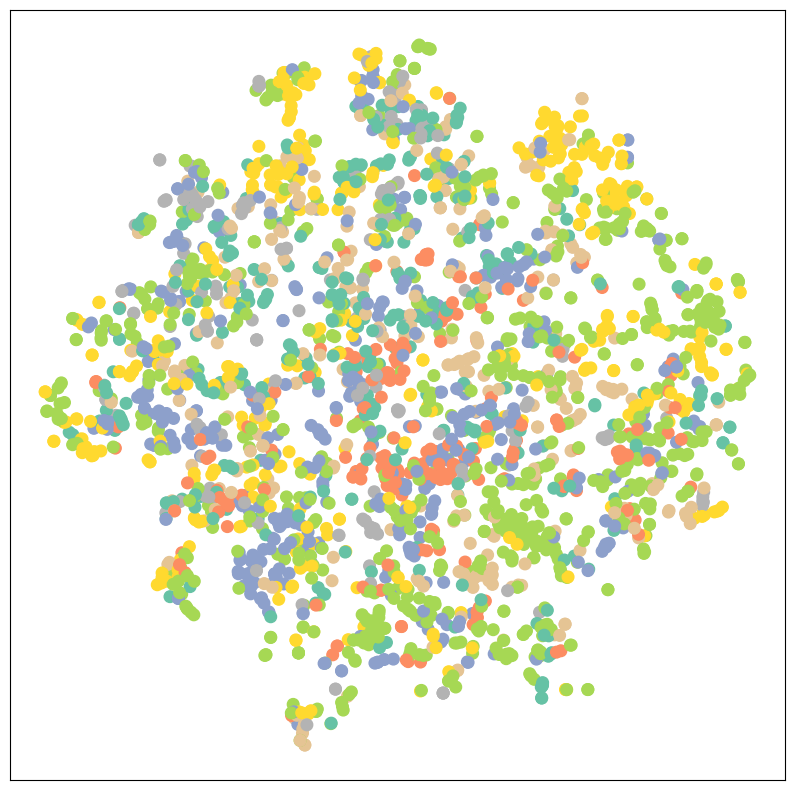

In [11]:
# Визуализируем работу сети до запуска её обучения

model1.eval()
out = model1(data.x, data.edge_index)
visualize(out, color=data.y)

In [12]:
# составим (скопируем из блокнота практики) функцию обучения

criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [13]:
# функцию валидации

def validate():
    model.eval()
    out = model(data.x, data.edge_index)
    val_pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = val_pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [14]:
# функцию тестирования модели

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

Реализую перебор параметров с подсчетом accuracy на валидационной выборке.

In [16]:
# Выполним перебор параметров сети.
# Перебирать будем learning rate

print('learning rate = 0.1')
model = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
for epoch in range(1, 101):
  loss = train()
val_acc = validate()
print(f'Val Accuracy: {val_acc:.4f}')
print()

del model
print('learning rate = 0.01')
model = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(1, 101):
  loss = train()
val_acc = validate()
print(f'Val Accuracy: {val_acc:.4f}')
print()

del model
print('learning rate = 0.001')
model = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
for epoch in range(1, 101):
  loss = train()
val_acc = validate()
print(f'Val Accuracy: {val_acc:.4f}')

learning rate = 0.1
Val Accuracy: 0.7580

learning rate = 0.01
Val Accuracy: 0.7840

learning rate = 0.001
Val Accuracy: 0.7060


Видим, что лучший результат показан при learning rate = 0.01

Используем далее именно это значение при обучении сети на большом количестве эпох

In [18]:
# прогоним данные на 300 эпохах обучения модели

del model
arr_loss = []
model = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(1, 301):
  loss = train()
  if epoch % 10 == 0:
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    arr_loss.append(loss)

test_acc = test()
print()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 010, Loss: 1.8261
Epoch: 020, Loss: 1.5431
Epoch: 030, Loss: 1.0609
Epoch: 040, Loss: 0.6826
Epoch: 050, Loss: 0.4839
Epoch: 060, Loss: 0.4034
Epoch: 070, Loss: 0.3024
Epoch: 080, Loss: 0.2736
Epoch: 090, Loss: 0.2072
Epoch: 100, Loss: 0.1960
Epoch: 110, Loss: 0.1745
Epoch: 120, Loss: 0.2011
Epoch: 130, Loss: 0.1868
Epoch: 140, Loss: 0.1400
Epoch: 150, Loss: 0.1393
Epoch: 160, Loss: 0.1047
Epoch: 170, Loss: 0.1546
Epoch: 180, Loss: 0.1260
Epoch: 190, Loss: 0.1312
Epoch: 200, Loss: 0.1141
Epoch: 210, Loss: 0.1064
Epoch: 220, Loss: 0.1043
Epoch: 230, Loss: 0.1229
Epoch: 240, Loss: 0.1170
Epoch: 250, Loss: 0.0972
Epoch: 260, Loss: 0.0952
Epoch: 270, Loss: 0.0995
Epoch: 280, Loss: 0.0686
Epoch: 290, Loss: 0.0770
Epoch: 300, Loss: 0.0610

Test Accuracy: 0.7910


**Визуализируем полученные результаты:**

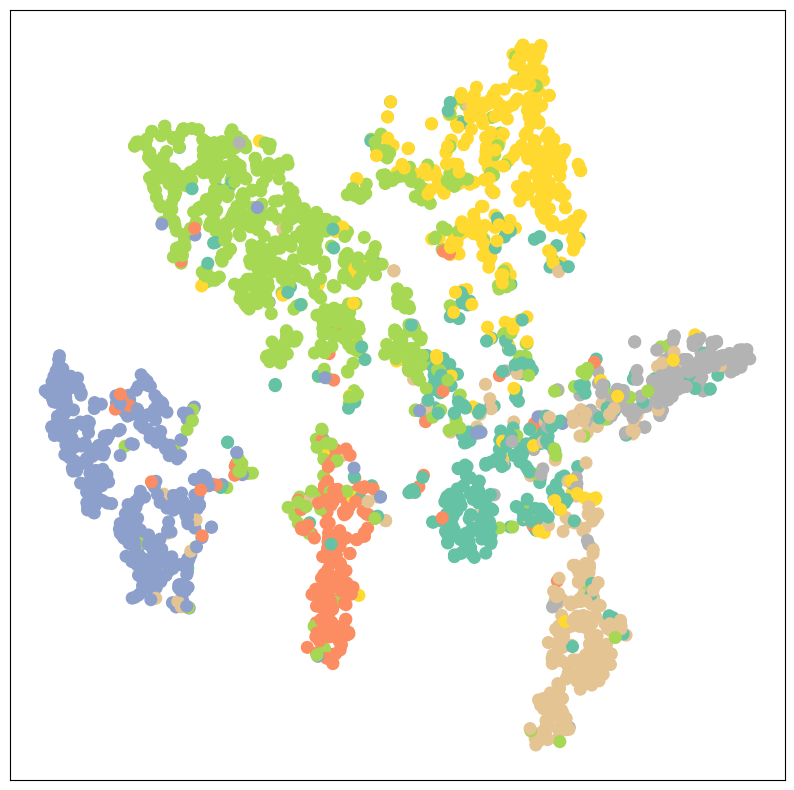

In [ ]:
# прогоним данные через модель,
# отключив для модели возможность
# обновления весов.
# отобразим результат с помощью ранее составленной функции

model.eval()

results = model(data.x, data.edge_index)
visualize(results, color=data.y)

**Выводы:**

Видим, что модель работает корректно.
<br> Выводя ошибку обучения каждые 10 эпох, мы наблюдаем быстрое снижение величины ошибки.
<br> Графический вывод показывает, что пройдя обучение, модель начала вполне отчётливо разделять классы, чего нельзя было сказать о модели до её обучения (по предыдущему графику).

**Дополнительная часть задания**

Реализация собственного слоя GCN

In [28]:
# Функции, используемые в конструируемом классе:

# функция вычисления ошибки
def loss_func(y, p, eps = 1e-8):
  return -np.mean(np.sum(y * np.log(p + eps), axis = 1))

# функция вычисления матрицы степеней вершин
def degree_m(A):
  D = np.diag(np.sum(A, axis = 1))
  return D

# лапласиан графа
def graph_lapl(A):
  D = degree_m(A)
  D_sqrt = np.sqrt(D)
  D_inv = np.linalg.pinv(D_sqrt)
  I = np.identity(len(A))
  return I - np.dot(D_inv, np.dot(A, D_inv))

# функции активации
# relu - между слоями
# softmax - после слоёв
def relu(x):
  return x * (x > 0)
def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


In [29]:
# составим класс, описывающий слой сети
# класс, как обычно, включает конструктор класса,
# метод forward для прямого прохода
# и метод backward для обратного

class myGCNConv:
  def __init__(self, in_params, out_params):
    self.W = np.random.randn(in_params, out_params)
    self.b = np.zeros((1, out_params))
    self.A, self.X = None, None

  def forward(self, X, A):
    self.A = A
    self.X = X
    L = graph_lapl(self.A)
    return np.dot(np.dot(L, self.X), self.W) + self.b

  def backward(self, er, lr):
    L = graph_lapl(self.A)
    out_data = np.dot(self.X.T, L)
    gradW = np.dot(out_data, er)
    gradb = np.sum(er, axis = 0, keepdims = True)
    self.W -= lr * gradW
    self.b -= lr * gradb
    return np.dot(L.T, np.dot(er, self.W.T))

In [30]:
# составим класс, использующий ранее составленные слои для сети
# в сети используется 3 слоя,
# а также функции для прямого прохода по сети
# и для обратного распространения ошибки

class myGCN:
    def __init__(self, hidden_channels1, hidden_channels2):
        self.conv1 = myGCNConv(dataset.num_features, hidden_channels1)
        self.conv2 = myGCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = myGCNConv(hidden_channels2, dataset.num_classes)

    def forward(self, x, A):
        x = self.conv1.forward(x, A)
        x = relu(x)
        x = self.conv2.forward(x, A)
        x = relu(x)
        x = self.conv3.forward(x, A)
        return softmax(x)

    def backward(self, y, y_p, alpha = 0.01):
      er = (y_p - y) / y.shape[0]
      gradConv3 = self.conv3.backward(er, alpha)
      gradConv2 = self.conv2.backward(gradConv3, alpha)
      gradConv1 = self.conv1.backward(gradConv2, alpha)
      return gradConv1, gradConv2, gradConv3

In [9]:
# Подготовим набор данных для обучения собственной модели
# Для этого объявим матрицу нулей размерности количества узлов в нашем графе.
# С помощью функции .edge_index переведём даные в COO format with shape [2, num_edges]
# После чего переведём их из тензоров в массивы нумпи с помощью функции numpy().
# Метки классов также переведём в формат массивов нумпи диагональной формы

adj_m = np.zeros((data.num_nodes, data.num_nodes))
edge_index = data.edge_index.numpy()
adj_m[edge_index[0], edge_index[1]] = 1
adj_m[edge_index[1], edge_index[0]] = 1
A = adj_m
y = data.y.numpy()
num_labels = len(np.unique(data.y))
y = np.eye(num_labels)[y]

In [1]:
# инициализируем модель
# и запустим обучение
# ошибки для каждой эпохи соберём в массив,
# который используется далее для отрисовки графика ошибок

myGCN = myGCN(hidden_channels1 = 16, hidden_channels2 = 16)
loss_arr = []
for epoch in range(1, 51):
    out = myGCN.forward(data.x, A)
    loss = loss_func(y[data.train_mask], out[data.train_mask])
    loss_arr.append(loss)
    print(f' epoch: {epoch}, loss = {loss}')
    myGCN.backward(y, out, alpha = 0.1)

 epoch: 1, loss = 4.167612937564698
 epoch: 2, loss = 4.111832309262031
 epoch: 3, loss = 4.104651854771125
 epoch: 4, loss = 4.088061230807419
 epoch: 5, loss = 4.0476502218743216
 epoch: 6, loss = 4.00297185600676
 epoch: 7, loss = 3.9562364754533292
 epoch: 8, loss = 3.9054731216471446
 epoch: 9, loss = 3.8515757831967026
 epoch: 10, loss = 3.7983799104580727
 epoch: 11, loss = 3.745134844841282
 epoch: 12, loss = 3.692393527554212
 epoch: 13, loss = 3.641196364465829
 epoch: 14, loss = 3.591207109842999
 epoch: 15, loss = 3.5437655006483
 epoch: 16, loss = 3.4987142292843463
 epoch: 17, loss = 3.456224146391283
 epoch: 18, loss = 3.4154010245566804
 epoch: 19, loss = 3.3760580366143413
 epoch: 20, loss = 3.3385538770638754
 epoch: 21, loss = 3.3026371363739693
 epoch: 22, loss = 3.2674546735474728
 epoch: 23, loss = 3.2336559814913253
 epoch: 24, loss = 3.2011078174434715
 epoch: 25, loss = 3.169891693593651
 epoch: 26, loss = 3.139879465634995
 epoch: 27, loss = 3.1111975548402664

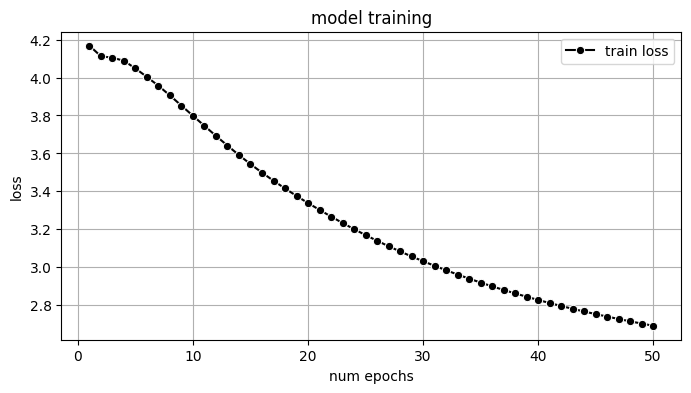

In [13]:
# выведем ошибки обучения для каждой эпохи на графике

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(x=range(1, 51), y=loss_arr, marker='o', color='k', label='train loss')
ax.set(xlabel='num epochs', ylabel='loss', title='model training')
ax.legend()
ax.grid(True)
plt.show()

**Выводы:**

Модель также работает корреткно. <br>
Об этом свидельствуют быстро снижающиеся значения функции ошибки при обучении.<br>
Видим, что начальное значение ошибки значительно выше, чем было при использовании библиотечной модели.<br>
Видимо по качеству данная модель уступит библиотечной, однако сравнить их на большом количестве эпох (например, 300 как для библиотечной модели) не представляется возможным ввиду того, что данная модель работает несоизмеримо медленнее библитечной, 300 эпох убучения заняли бы наверное часов 10.